In [54]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS,Adam
from tqdm import tqdm
import scipy.io
import os
import sys

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from model.pinn import PINNs
from model_parametrized.pinn_ff import PINNff

In [55]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'
else:
    print("CUDA not available, using CPU.")
    device = 'cpu'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: False
CUDA not available, using CPU.


In [56]:
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


In [57]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [58]:
# Train PINNs 
# model = PINNs(in_dim=3, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model = PINNff(in_dim=3, 
                hidden_dim=512,
                out_dim=1,
                num_layer=4,
                init_act_func="sin",
                subseq_activ_func="gelu").to(device)

model.apply(init_weights)
# optim = Adam(model.parameters(), line_search_fn='strong_wolfe')
optim = Adam(model.parameters(), lr=0.001)

print(model)
print(get_n_params(model))

PINNff(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): SinAct()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527873


C:\Users\a.almasri\AppData\Local\Temp\ipykernel_19064\93869651.py:18: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


In [16]:
loss_track = []
model.train() # set to training mode
beta = 5
beta_tensor1 = torch.full_like(x_res, beta)
beta_tensor2 = torch.full_like(x_left, beta)
beta_tensor3 = torch.full_like(x_upper, beta)
for i in tqdm(range(100)):
    total_loss_res = 0.0
    total_loss_ic = 0.0
    total_loss_bs = 0.0
    
    pred_res = model(x_res, t_res, beta_tensor1)
    pred_left = model(x_left, t_left, beta_tensor2)
    pred_right = model(x_right, t_right, beta_tensor2)
    pred_upper = model(x_upper, t_upper, beta_tensor3)
    pred_lower = model(x_lower, t_lower, beta_tensor3)

    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t + beta * u_x) ** 2)
    loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

    loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

    loss = loss_res + loss_bc + loss_ic
    optim.zero_grad()
    loss.backward()
    optim.step()


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


In [45]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.019235, Loss_BC: 0.035212, Loss_IC: 0.345658
Train Loss: 0.400105


In [46]:
# %%
from pathlib import Path

base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [68]:
def analytical_solution(x, t, beta):
    return torch.sin(x - beta *t)

C:\Users\a.almasri\AppData\Local\Temp\ipykernel_19064\3877502231.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
C:\Users\a.almasri\AppData\Local\Temp\ipykernel_19064\3877502231.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

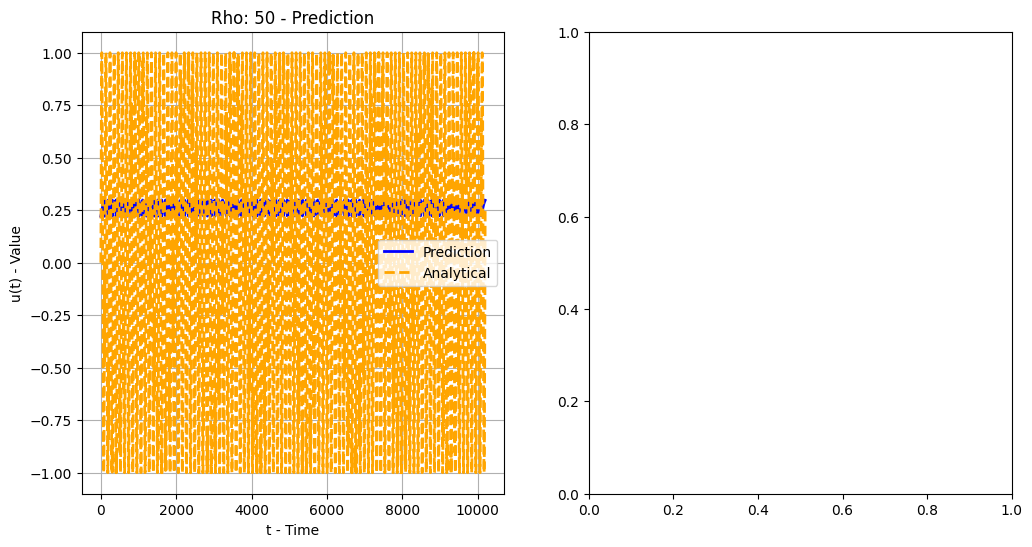

In [71]:
# Get test points for the current rho
x_test, t_test= x_res, t_res
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

rho_test = torch.full_like(x_test, 50).to(device)

# Compute analytical solution
u_analytical = analytical_solution(x_test, t_test, 50).cpu().detach().numpy().reshape(-1)

# Compute best model predictions
with torch.no_grad():
    pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
    pred = pred.cpu().detach().numpy().reshape(-1)

# Compute error
abs_error = np.abs(u_analytical - pred)



percentage_error = (abs_error / np.maximum(u_analytical, 1e-8)) * 100  # Avoid division by zero

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(pred, label="Prediction", color="blue", linewidth=2)
plt.plot(u_analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
plt.title(f"Rho: {50} - Prediction")
plt.xlabel("t - Time")  # Horizontal axis label
plt.ylabel("u(t) - Value")  # Vertical axis label
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x_test.cpu().numpy(), abs_error, label="Absolute Error", color="red", linewidth=2)
plt.title(f"Rho: {50} - Absolute Error")
plt.xlabel("x - Space")  # Horizontal axis label
plt.ylabel("delta u(x)")  # Vertical axis label
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# plt(pred, label="Prediction", color="blue", linewidth=2)
# plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
# set_title(f"Rho: {50} - Prediction")
# set_xlabel("t - Time")  # Horizontal axis label
# set_ylabel("u(t) - Value")  # Vertical axis label
# legend()



# #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
# plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
# set_title(f"Rho: {50} - Relative Error (%)")
# set_xlabel("t - Time")  # Horizontal axis label
# set_ylabel("delta u(t) (%)")  # Vertical axis label
# legend()

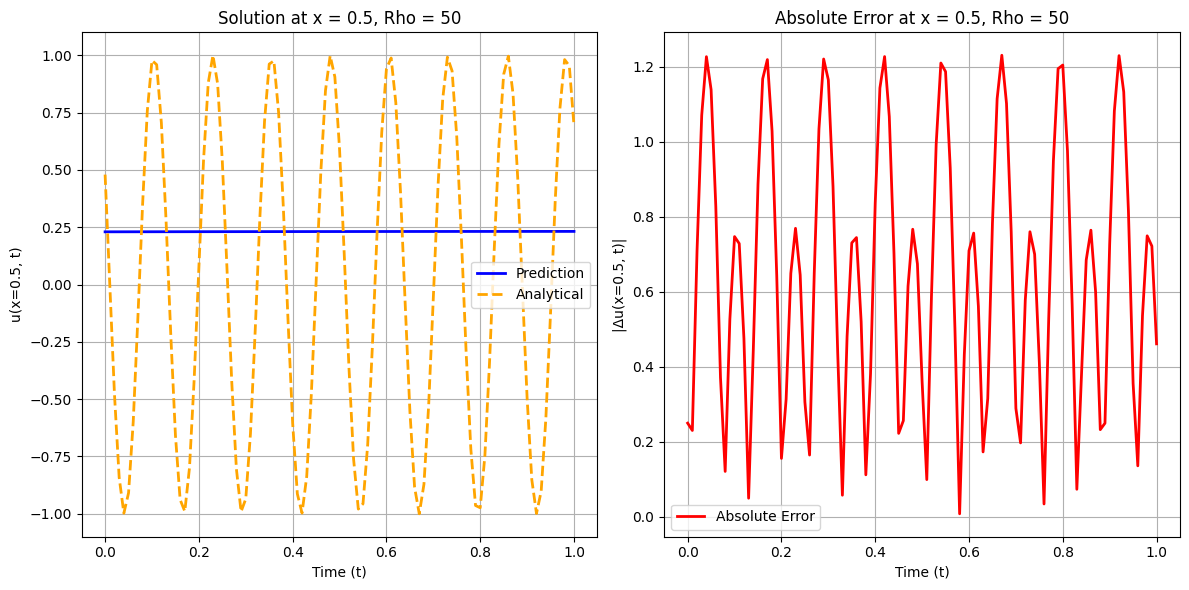

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume these are your original grid generation parameters or data
# Example:
x_range = [0, 1] # Replace with your actual x range
t_range = [0, 1] # Replace with your actual t range
x_num = 101      # Replace with your actual number of x points
t_num = 101      # Replace with your actual number of t points

# Generate the original 1D arrays for x and t
x_linspace = np.linspace(x_range[0], x_range[1], x_num)
t_linspace = np.linspace(t_range[0], t_range[1], t_num)

# --- MODIFICATIONS START HERE ---

# 1. Choose the specific x-value you want to plot
x_target = 0.5  # <<<--- CHANGE THIS to your desired x-coordinate
# Make sure x_target is within your original x_range

# 2. Prepare test data for this single x over all t
t_test_np = t_linspace                        # Use the original time points
x_test_np = np.full_like(t_test_np, x_target) # Create an array filled with x_target

# 3. Convert to tensors, ensuring correct shape (N, 1) for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Make sure device is defined
x_test = torch.tensor(x_test_np, dtype=torch.float32).view(-1, 1).to(device)
t_test = torch.tensor(t_test_np, dtype=torch.float32).view(-1, 1).to(device)

# Add requires_grad if you need gradients later (usually not needed for plotting)
# x_test.requires_grad_(True)
# t_test.requires_grad_(True)

# Keep rho fixed for these points
rho_val = 50
rho_test = torch.full_like(x_test, rho_val).to(device)

# --- MODIFICATIONS END HERE ---


# Assume 'analytical_solution' and 'model' are defined elsewhere
# Define dummy functions if needed for testing this snippet:
# def analytical_solution(x, t, rho):
#     return torch.sin(np.pi * x) * torch.exp(-rho * t / 10)
# class DummyModel(torch.nn.Module):
#     def forward(self, x, t, rho):
#         return torch.sin(np.pi * x) * torch.exp(-rho * t / 11) # Slightly different
# model = DummyModel().to(device)


# Compute analytical solution for the specific x and range of t
# Ensure your analytical_solution function handles (N, 1) input tensors
u_analytical = analytical_solution(x_test, t_test, rho_val).cpu().detach().numpy().flatten() # Use flatten or squeeze

# Compute model predictions for the specific x and range of t
with torch.no_grad():
    # Ensure your model handles (N, 1) input tensors and returns (N, 1) output
    pred = model(x_test, t_test, rho_test)[:, 0:1] # Select the correct output dim if needed
    pred = pred.cpu().detach().numpy().flatten() # Use flatten or squeeze

# Compute error
abs_error = np.abs(u_analytical - pred)
percentage_error = (abs_error / np.maximum(np.abs(u_analytical), 1e-8)) * 100 # Avoid division by zero, use abs for denominator

# --- PLOTTING MODIFICATIONS ---

plt.figure(figsize=(12, 6))

# Plot 1: Solution vs. Time for fixed x
plt.subplot(1, 2, 1)
plt.plot(t_test_np, pred, label="Prediction", color="blue", linewidth=2) # x-axis is time
plt.plot(t_test_np, u_analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2) # x-axis is time
plt.title(f"Solution at x = {x_target}, Rho = {rho_val}")
plt.xlabel("Time (t)") # Correct x-axis label
plt.ylabel(f"u(x={x_target}, t)") # Correct y-axis label
plt.legend()
plt.grid(True) # Use boolean True

# Plot 2: Absolute Error vs. Time for fixed x
plt.subplot(1, 2, 2)
plt.plot(t_test_np, abs_error, label="Absolute Error", color="red", linewidth=2) # x-axis is time
plt.title(f"Absolute Error at x = {x_target}, Rho = {rho_val}")
plt.xlabel("Time (t)") # Correct x-axis label
plt.ylabel(f"|Δu(x={x_target}, t)|") # Correct y-axis label
# Optional: Use log scale for error if it spans many orders of magnitude
# plt.yscale('log')
plt.legend()
plt.grid(True) # Use boolean True

plt.tight_layout()
plt.show()